# Active contraction of a single beam

## Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace)
from dolfinx.fem.petsc import NonlinearProblem, apply_lifting, assemble_matrix, assemble_vector, set_bc
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunction, TrialFunction, grad, sqrt, derivative, dot, split, Jacobian,\
                  diag, as_vector,outer,cos,sin,variable,diag,action,diff,inner)

# basix finite elements (necessary for dolfinx v0.8.0)
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

## Import mesh

In [2]:
mesh_folder="example_files/meshes/"
mesh_filename="line_mesh_rotated.xdmf"

with XDMFFile(MPI.COMM_WORLD, mesh_folder+mesh_filename, "r") as xdmf:
    domain = xdmf.read_mesh(name="Grid")
domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

x = ufl.SpatialCoordinate(domain)

## Visualize the reference configuration

In [3]:
# import pyvista
# pyvista.set_jupyter_backend('html')
# from dolfinx.plot import vtk_mesh
# pyvista.start_xvfb()

# # initialize a plotter
# plotter = pyvista.Plotter()

# # Add the mesh.
# topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
# grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
# plotter.add_mesh(grid, show_edges=True) 

# labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
# plotter.add_axes(**labels)

# plotter.screenshot("example_files/images/mesh.png")

# from IPython.display import Image
# Image(filename="example_files/images/mesh.png") 

## Function spaces

In [4]:
# Define the function space, both vectorial and scalar
Ue = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # for displacement. is shape the same as dim?
Te = element("Lagrange", domain.basix_cell(), 1) # for rotation
Th = mixed_element([Ue, Te]) # Taylor-Hood element
V = functionspace(domain, Th) # Total space for all DOFs

# Define the actual functions with the required DOFs
v = Function(V, name="Generalized displacement")
u, theta = split(v) # displacement u and rotation theta

# Define test functions
v_ = TestFunction(V)
u_, theta_ = split(v_)

# Define trial functions needed for automatic differentiation
dv = TrialFunction(V)

# Define the function space for the rotation?
VR = functionspace(domain, element("DG", domain.basix_cell(), 0, shape=(2, 2)))
V0 = functionspace(domain, element("DG", domain.basix_cell(), 0))

## Material parameters

In [5]:
# Geometric Properties
S = 6.0 # cross-sectional area
I = 2.0 # Area moment
E = 720.0 # Elastic modulus
nu = 0.0 # Poisson's Ratio

G = E/(2*(1+nu)) # Shear Modulus
kappa = 1.0 # Shear correction

# Beam Stiffness
ES = E*S
GS = G*S
GS_2 = G*S*kappa
EI = E*I

## Identify the boundaries of the domain and assign Dirichelet boundary conditions

In this problem, there is no Dirichlet boundary condition. We will implement the Robin bounary condition later.

In [6]:
# Identify the boundary
def boundary_x_left(x):
    return np.isclose(x[0], 0.0)

fdim = domain.topology.dim - 1
facet_indices = mesh.locate_entities(domain, fdim, boundary_x_left)
facet_indices = np.array(facet_indices, dtype=np.int32)
facet_markers = np.full_like(facet_indices, 10, dtype=np.int32)
sorted_facet_indices = np.argsort(facet_indices)

# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facet_indices], facet_markers[sorted_facet_indices])

fixed_disp = Constant(domain, PETSc.ScalarType(0.0))
left_dofs_u1 = fem.locate_dofs_topological(V.sub(0).sub(0), facet_tags.dim, facet_tags.find(10))
left_dofs_u2 = fem.locate_dofs_topological(V.sub(0).sub(1), facet_tags.dim, facet_tags.find(10))
left_dofs_rot = fem.locate_dofs_topological(V.sub(1),facet_tags.dim,facet_tags.find(10))

# Assign boundary conditions
bc_left_u1 = dirichletbc(fixed_disp, left_dofs_u1, V.sub(0).sub(0))
bc_left_u2 = dirichletbc(fixed_disp, left_dofs_u2, V.sub(0).sub(1))
bc_left_rot = dirichletbc(fixed_disp, left_dofs_rot, V.sub(1))

# bcs = [bc_left_u1,bc_left_u2,bc_left_rot]
bcs = []

## Define boundary and volume integration measure

In [7]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

## 2D beam kinematics

In [8]:
Jac = Jacobian(domain)
gdim = domain.geometry.dim
Jac = as_vector([Jac[i,0] for i in range(gdim)])
g01 = Jac/sqrt(dot(Jac,Jac))
g02 = as_vector([-g01[1], g01[0]])

r01 = outer(g01, as_vector([1, 0]))
r02 = outer(g02, as_vector([0, 1]))
R0 = r01 + r02

# Define functions for beams
def tgrad(u): # directional derivative wrt beam centerline in the initial configuration
    return dot(grad(u), g01)

def rotation_matrix(theta):
    return as_vector([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

Rot = rotation_matrix(theta)

# 2D beam kinematics
def gamma_value(t):
    return t

gamma = Constant(domain, PETSc.ScalarType(1.0)) # growth stretch
lmbda = variable(dot(R0.T,dot(Rot.T,g01 + tgrad(u)))) # total stretch
alpha = variable(lmbda/gamma) # mechanical stretch
defo = variable(lmbda - as_vector([1,0])) # total_strain with rotationss
defo_e = variable(alpha - as_vector([1,0]))# mechanical strain with rotations
curv =  variable(tgrad(theta)) # curvature in initial configuration

## Weak form

In [9]:
# Constitutive Equation
C_N = diag(as_vector([ES, GS_2]))

# Applied Load:
F_max = Constant(domain,(0.0,0.0))
M_max = Constant(domain,0.0)

# Hyperelastic strain energy density function
strain_energy = 0.5 * (dot(defo_e, dot(C_N, defo_e)) + EI*curv**2)

# Variational form
F_int = derivative(strain_energy*gamma*dx,v,v_)
F_ext = (-M_max*theta_ + dot(F_max, u_))*ds
residual = F_int - F_ext

## Apply Robin boundary conditions

In [10]:
# class for Robin boundary
class RobinBC():
    def __init__(self,marker,r,s,constrain_rot=False):
        # self.bc = r * inner(u_trial-s,u_)*ds(marker)
        if constrain_rot is False:
            self.bc = r*inner(u-s,u_)*ds(marker)
        elif constrain_rot is True:
            self.bc = r*inner(theta-s,theta_)*ds(marker)

# Robin boundary parameters
r = 1000
s = Constant(domain,(0.0,0.0))
s_rot = Constant(domain,0.0)

robin_bcs = [
    RobinBC(10,r,s),
    RobinBC(10,r,s_rot,constrain_rot=True)
]

# add the Robin term to the residual
robin_term = 0
for rbc in robin_bcs:
    robin_term+=rbc.bc
residual += robin_term

# compute the tangent form of the residual
tangent_form = derivative(residual, v, dv)

## Define the nonlinear variational problem

In [11]:
# Optimization options for the form compiler

# Set up nonlinear problem
problem = NonlinearProblem(residual, v, bcs, tangent_form)

# The global Newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-12
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

## Setup output files

In [12]:
results_name = "robin_single_rotated_beam_contract"

U1 = element("DG", domain.basix_cell(), 1, shape=(2,)) # for displacement
V2 = functionspace(domain, U1) # vector function space

u_vis = Function(V2)
u_vis.name = "displacement"

file_results = VTXWriter(
    MPI.COMM_WORLD,
    "example_files/fem_results/"+results_name+".bp",
    [
        u_vis
    ],
    engine="BP4",
)

def writeResults(t):
    # Output field interpolation
    u_vis.interpolate(v.sub(0))

    # Write output fields
    file_results.write(t)

## Define functions to extract reaction forces from residual

In [13]:
def one(x):
    values = np.zeros((1,x.shape[1]))
    values[0] = 1.0
    return values


# Extract reaction forces from the left boundary
v_rx = Function(V)
v_ry = Function(V)
bcRx = dirichletbc(v_rx,left_dofs_u1)
bcRy = dirichletbc(v_ry,left_dofs_u2)
bcs_rxn = [bcRx,bcRy]

## Define functions to extract reaction forces by differentiating the strain energy w.r.t the mechanical strain

In [14]:
def project(e, target_func, bcs=[]):
    """Project UFL expression.

    Note
    ----
    This method solves a linear system (using KSP defaults).

    """

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    dx = ufl.dx(V.mesh)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    v = ufl.TrialFunction(V)
    a = dolfinx.fem.form(ufl.inner(v, w) * dx)
    L = dolfinx.fem.form(ufl.inner(e, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setType("bcgs")
    solver.getPC().setType("bjacobi")
    solver.rtol = 1.0e-05
    solver.setOperators(A)
    solver.solve(b, target_func.x.petsc_vec)
    assert solver.reason > 0
    target_func.x.scatter_forward()

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()

DG_func = functionspace(domain, ("DG",1,(domain.geometry.dim,)))
int_force = Function(DG_func, name='force')

## Solve the nonlinear problem

In [15]:
Tlist = np.linspace(1,.5,20)

v_reac = Function(V)

force_x = []
force_y = []
force_diff = []
force_diff_whole_array = []
force_diff_total_strain = []
ii=0
for t in Tlist:
    # Apply growth
    gamma.value = gamma_value(t)

    # Solve the problem
    try:
        (iter,converged) = solver.solve(v)
    except: # Break the loop if solver fails
        print("Ended early")
        break

    ii+=1

    # Collect results from MPI ghost processes
    v.x.scatter_forward()

    # Write output to file
    writeResults(ii)

    # Compute internal force using only the mechanical strain
    project(diff(strain_energy,defo_e), int_force)
    force_diff_whole_array.append(int_force.x.array)
    force_diff.append(int_force.x.array[0])

    # Compute force from residual
    # v.sub(0).sub(0).interpolate(one)
    v_rx.sub(0).sub(0).interpolate(one)
    virtual_work_form_x = fem.form(action(robin_term,v_rx))
    fem.set_bc(v_rx.x.array,bcs_rxn)
    Rx = fem.assemble_scalar(virtual_work_form_x)
    force_x.append(Rx)

    # v.sub(0).sub(1).interpolate(one)
    v_ry.sub(0).sub(1).interpolate(one)
    virtual_work_form_y = fem.form(action(robin_term,v_ry))
    fem.set_bc(v_ry.x.array,bcs_rxn)
    Ry = fem.assemble_scalar(virtual_work_form_y)
    force_y.append(Ry)

    # Print progress of calculation
    if ii%1 == 0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f"Increment: {ii} | Contraction: {t} | Iter: {iter}")

Increment: 1 | Contraction: 1.0 | Iter: 2
Increment: 2 | Contraction: 0.9736842105263158 | Iter: 3
Increment: 3 | Contraction: 0.9473684210526316 | Iter: 3
Increment: 4 | Contraction: 0.9210526315789473 | Iter: 3
Increment: 5 | Contraction: 0.8947368421052632 | Iter: 3
Increment: 6 | Contraction: 0.868421052631579 | Iter: 3
Increment: 7 | Contraction: 0.8421052631578947 | Iter: 3
Increment: 8 | Contraction: 0.8157894736842105 | Iter: 3
Increment: 9 | Contraction: 0.7894736842105263 | Iter: 3
Increment: 10 | Contraction: 0.7631578947368421 | Iter: 3
Increment: 11 | Contraction: 0.736842105263158 | Iter: 3
Increment: 12 | Contraction: 0.7105263157894737 | Iter: 3
Increment: 13 | Contraction: 0.6842105263157895 | Iter: 3
Increment: 14 | Contraction: 0.6578947368421053 | Iter: 3
Increment: 15 | Contraction: 0.631578947368421 | Iter: 3
Increment: 16 | Contraction: 0.6052631578947368 | Iter: 3
Increment: 17 | Contraction: 0.5789473684210527 | Iter: 3
Increment: 18 | Contraction: 0.5526315789

## Validate the code against analytical solutions (Reaction forces)

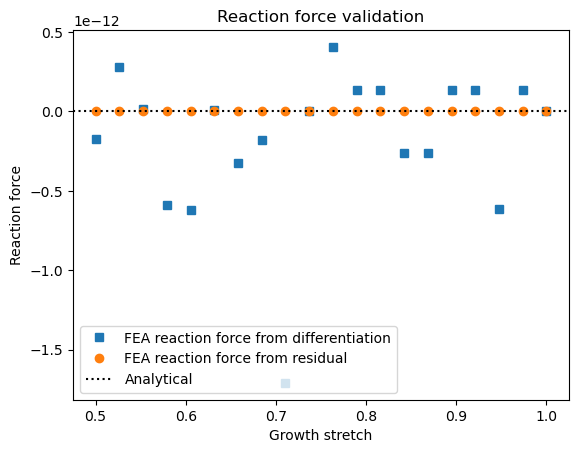

In [ ]:
force_x = np.array(force_x)
force_y = np.array(force_y)

force_residual = np.sqrt(force_x**2 + force_y**2)

plt.figure()
plt.plot(Tlist,force_diff, marker = 's', ls = 'None', label = 'FEA reaction force from differentiation')
plt.plot(Tlist,force_residual, marker = 'o', ls = 'None', label = 'FEA reaction force from Robin term')
plt.axhline(ls = ':', c = 'k', label = 'Analytical')
plt.xlabel('Growth stretch')
plt.ylabel('Reaction force')
plt.title('Reaction force validation')
plt.legend()